### Imports

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV 
from sklearn.svm import SVC

### Loading and Merging data

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train['train_test'] = 1
test['train_test'] = 0
all_data = pd.concat([train,test], ignore_index = True)

### EDA and Data preprocessing 

In [3]:
all_data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
 12  train_test   1309 non-null   int64  
dtypes: float64(3), int64(5), object(5)
memory usage: 133.1+ KB


In [4]:
all_data.describe() 

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,train_test
count,1309.000000,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,1309.000000
mean,655.000000,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479,0.680672
std,378.020061,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668,0.466394
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800,0.000000
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,1.000000
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000,1.000000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200,1.000000


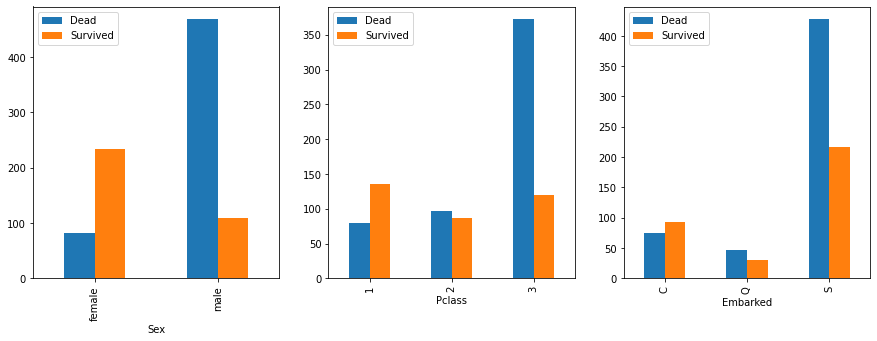

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
cat_columns = ['Sex','Pclass','Embarked']
for i in range(len(cat_columns)):
    curr_feature = cat_columns[i]
    train.groupby([curr_feature, 'Survived'])['PassengerId'].count().unstack().plot(kind = 'bar', stacked = False, ax = axes[i])
    axes[i].legend(['Dead','Survived'])

In [6]:
all_data['isChild'] = 0
all_data.loc[all_data['Age'] < 15, 'isChild'] = 1

In [7]:
all_data['Age_isMissing_mean_temp'] = all_data.groupby(['Pclass', 'Sex', 'isChild']).Age.transform('median')
all_data.loc[all_data.Age.isnull(), 'Age'] = all_data.loc[all_data.Age.isnull(), 'Age_isMissing_mean_temp']
all_data.drop('Age_isMissing_mean_temp', axis = 1, inplace = True)

In [8]:
all_data['Cabin_initial'] = all_data.Cabin.apply(lambda x: str(x)[0])
def group_deck(deck):
    if(deck in ['A','B','C','T']):
        return "ABC"
    elif(deck in ['D','E']):
        return "DE"
    elif (deck in ['F', 'G']):
        return "FG"
    else:
        return "N"
all_data['Cabin_deck'] = all_data['Cabin_initial'].apply(group_deck)

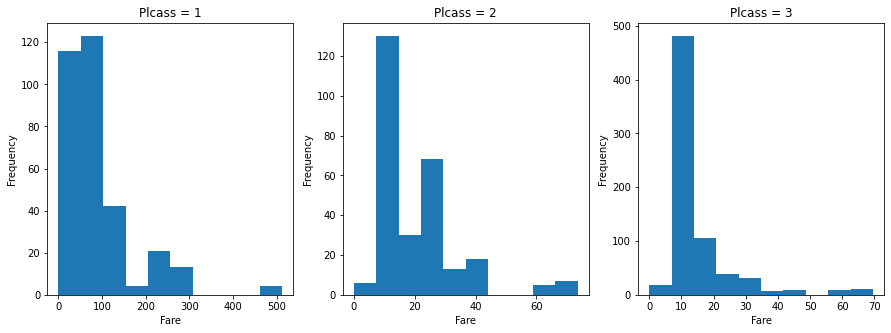

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
for i in range(3):
    ax = all_data[all_data.Pclass == (i+1)].Fare.plot.hist(ax = axes[i], title='Plcass = ' + str(i+1))
    ax.set_xlabel("Fare")

In [10]:
ticket_count = all_data.groupby('Ticket').PassengerId.count()
all_data['Ticket_count'] = all_data['Ticket'].map(ticket_count)
all_data['Fare_individual'] = all_data['Fare']/all_data['Ticket_count']

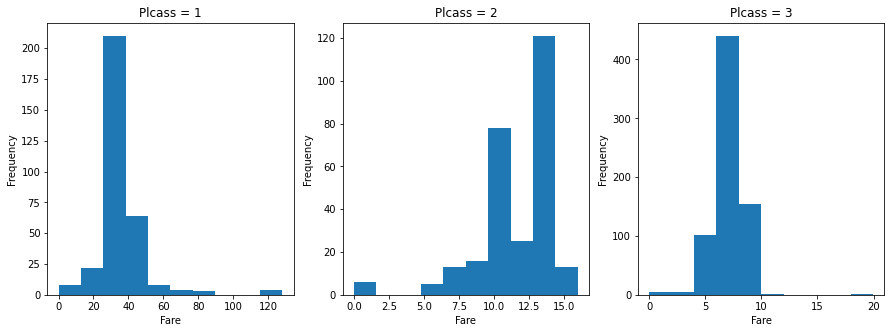

In [11]:
# Figure 3: plot the distribution of Fare_individual in each Pclass with more specific bins
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
for i in range(3):
    ax = all_data[all_data.Pclass == (i+1)].Fare_individual.plot.hist(ax = axes[i], title='Plcass = ' + str(i+1))
    ax.set_xlabel("Fare")

In [12]:
all_data.loc[all_data.Fare_individual.isnull(), 'Fare_individual'] = all_data[all_data['Pclass'] == 3].Fare_individual.median()
all_data.loc[all_data.Fare_individual.isnull(), 'Fare'] = all_data[all_data['Pclass'] == 3].Fare_individual.median()

In [13]:
all_data['Pclass_startingPrice'] = 0
all_data.loc[all_data.Pclass==1, 'Pclass_startingPrice'] = 25
all_data.loc[all_data.Pclass==2, 'Pclass_startingPrice'] = 10
all_data.loc[all_data.Pclass==3, 'Pclass_startingPrice'] = 7
all_data['Fare_differenceFromStart'] = all_data.Fare_individual - all_data.Pclass_startingPrice

In [14]:
all_data.loc[all_data.Embarked.isnull(), 'Embarked'] = 'C'

In [15]:
all_data['FamilySize'] = all_data.Parch + all_data.SibSp + 1

In [16]:
all_data['GroupSize'] = all_data[['Ticket_count', 'FamilySize']].max(axis = 1)

In [17]:
all_data.loc[all_data.Sex == 'male', 'Sex'] = 1
all_data.loc[all_data.Sex == 'female', 'Sex'] = 0

In [18]:
features_to_use = ['Pclass', 'Sex', 'Age', 'Embarked', 'train_test', 'Cabin_deck', 
                   'Fare_individual', 'Fare_differenceFromStart', 'GroupSize']
all_features_train = all_data[features_to_use].copy()
all_features_train.Pclass = all_features_train.Pclass.astype(str)
all_features_train = pd.get_dummies(all_features_train, columns = ['Pclass', 'Embarked','Cabin_deck'])
scaler = StandardScaler()
to_be_scaled = ['Age', 'Fare_individual', 'Fare_differenceFromStart','GroupSize']
all_features_train[to_be_scaled] = scaler.fit_transform(all_features_train[to_be_scaled])

In [19]:
x_train = all_features_train[all_features_train.train_test == 1].copy()
x_train.drop('train_test', axis = 1, inplace = True)
x_test = all_features_train[all_features_train.train_test == 0].copy()
x_test.drop('train_test', axis = 1, inplace = True)
y_train = all_data[all_data.train_test == 1].Survived

In [20]:
train_temp = all_data[all_data.train_test == 1].copy()
test_temp = all_data[all_data.train_test == 0].copy()

ticket_train_list = train_temp.Ticket.value_counts().index.tolist()
ticket_test_list = test_temp.Ticket.value_counts().index.tolist()
ticket_only_test_list = list(set(ticket_test_list) - set(ticket_train_list))

all_data['Ticket_survivalRate'] = 0
all_data['Ticket_survivalRate'] = all_data['Ticket'].apply(lambda x: 1 if x in ticket_only_test_list else 0)
all_data.loc[all_data.Ticket_count < 2, 'Ticket_survivalRate'] = 1

all_data['Ticket_survivalRate'] = all_data['Ticket'].map(all_data[all_data.Ticket_survivalRate == 0].groupby('Ticket').Survived.mean())
all_data['Ticket_survivalRate'] = all_data['Ticket_survivalRate'].fillna(0)

In [21]:
all_data['FirstName'] = all_data.Name.apply(lambda x: x.split(',')[0].strip())

train_temp = all_data[all_data.train_test == 1].copy()
test_temp = all_data[all_data.train_test == 0].copy()

FirstName_train_list = train_temp.FirstName.value_counts().index.tolist()
FirstName_test_list = test_temp.FirstName.value_counts().index.tolist()
FirstName_only_test_list = list(set(FirstName_test_list) - set(FirstName_train_list))

all_data['Family_survivalRate'] = 0
all_data['Family_survivalRate'] = all_data['FirstName'].apply(lambda x: 1 if x in FirstName_only_test_list else 0)
all_data.loc[all_data.FamilySize < 2, 'Family_survivalRate'] = 1

all_data['Family_survivalRate'] = all_data['FirstName'].map(all_data[all_data.Family_survivalRate == 0].groupby('FirstName').Survived.mean())
all_data['Family_survivalRate'] = all_data['Family_survivalRate'].fillna(0)

In [22]:
all_data['SurvivalRate'] = (all_data['Family_survivalRate'] + all_data['Ticket_survivalRate'])/2

In [23]:
x_train['SurvivalRate'] = all_data[all_data.train_test == 1]['SurvivalRate']
x_test['SurvivalRate'] = all_data[all_data.train_test == 0]['SurvivalRate']

### Modeling

In [25]:
svc = SVC()
param_grid = [{'kernel': ['rbf'], 'gamma': [.1,.5,1,2,5,10],
                                  'C': [.1, 1, 10, 100, 1000]},
                                 {'kernel': ['linear'], 'C': [.1, 1, 10, 100, 1000]},
                                 {'kernel': ['poly'], 'degree' : [2,3,4,5], 'C': [.1, 1, 10, 100, 1000]}]
clf_svc = GridSearchCV(svc, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_svc = clf_svc.fit(x_train,y_train)
print(best_clf_svc.best_score_)
print(best_clf_svc.best_params_)

Fitting 5 folds for each of 55 candidates, totalling 275 fits
0.8787709497206704
{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}


In [27]:
svc = SVC(random_state=1, C = 1, degree = 2, kernel = 'poly')
svc.fit(x_train, y_train)
y_pred_test_svc = svc.predict(x_test)
submission = {'PassengerId': all_data[all_data.train_test == 0].PassengerId, 'Survived': y_pred_test_svc.astype(int)}
submission = pd.DataFrame(data = submission)
submission.to_csv('Submission.csv', index=False)